# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lib.utils as utils
import yaml

# Reading In Model Metrics

In [3]:
df = pd.read_csv("metric_seed1.csv")
df

,val_mae,test_mae,test_rmse
0,59742.062,53139.8050,349243.750
1,19856.299,17575.5570,125415.270
2,15039.944,12867.9600,91571.250
3,13273.958,9995.8090,62587.207
4,12781.422,9133.1780,61111.008
5,11537.903,8744.8770,56918.950
6,11891.605,8856.7160,58590.016
7,9494.588,6640.4907,46418.970
8,9342.224,6435.0825,40443.973
9,9037.473,6204.2340,41694.950


# Final Metrics (Population / 1,000)

In [4]:
df.iloc[-1, :] / 1000

val_mae       7.600173
test_mae      5.145163
test_rmse    38.471164
Name: 11, dtype: float64

# Obtain Percentages of Data Used Per Iteration During Training

In [5]:
# Load Config File
with open("data/model/dcrnn_cov.yaml") as f:
    supervisor_config = yaml.safe_load(f)

# Read in Data From Config File
data, search_data_x, search_data_y = utils.load_dataset(**supervisor_config.get('data'))

# Calculate Total Data Across Train, Test, and Val Datasets
types = ["train", "val", "test"]
total_data_len = sum([np.load(f"data/data/{item}.npz", \
                              allow_pickle=True)["x"].shape[0] for item in types])

print(f"Initial Training: {data["x_train"].shape[0]}")

# Base Loop To Get Percent Per Iteration
all_percents = []
for i in range(1, 13):
    # Reward and Index List at Iteration "i"
    reward_list = np.load(f"seed1/reward_list/itr{i}.npy")
    index_list = np.load(f"seed1/index_list/itr{i}.npy")

    # The Selected Data For the Iteration
    selected_ind = np.argmax(np.array(reward_list))
    selected_data_x = [search_data_x[i] for i in index_list[selected_ind]]
    selected_data_y = [search_data_y[i] for i in index_list[selected_ind]]

    # Preprocessing Before Creating New Training Dataset
    selected_data = {}
    selected_data['x'] = selected_data_x
    selected_data['y'] = selected_data_y
    search_config = supervisor_config.get('data').copy()
    search_config['selected_data'] = selected_data
    search_config['previous_data'] = data

    # Create New Training Dataset
    data = utils.generate_new_trainset(**search_config)

    # Get the Dataset Shape and Percent of Data Used To Train
    print(f"Train Iteration {i}: {data["x_train"].shape[0]}")
    all_percents.append(data["x_train"].shape[0] / total_data_len)

Initial Training: 1728
Train Iteration 1: 2202
Train Iteration 2: 2571
Train Iteration 3: 3009
Train Iteration 4: 3366
Train Iteration 5: 3720
Train Iteration 6: 4155
Train Iteration 7: 4557
Train Iteration 8: 4953
Train Iteration 9: 5337
Train Iteration 10: 5742
Train Iteration 11: 6150
Train Iteration 12: 6507


In [6]:
all_percents

[0.10536893482629917,
 0.1230261269020959,
 0.1439850703416595,
 0.16106804478897502,
 0.17800746482917026,
 0.19882285386161355,
 0.21805914441573357,
 0.23700832615561299,
 0.2553832902670112,
 0.2747631352282515,
 0.29428653459661214,
 0.31136950904392763]

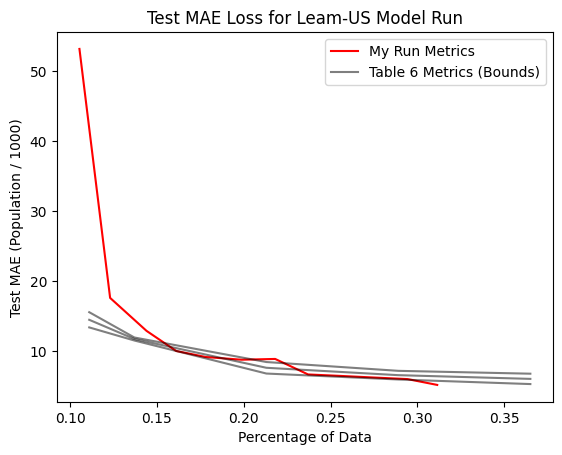

In [13]:
plt.ylabel("Test MAE (Population / 1000)")
plt.xlabel("Percentage of Data")
plt.title("Test MAE Loss for Leam-US Model Run")
plt.plot(all_percents, df["test_mae"]/1000, color="red", label="My Run Metrics")

plt.plot([0.111, 0.137, 0.213, 0.289, 0.365], \
         [14.447, 11.704, 7.593, 6.539, 6.008], \
            color="black", label="Table 6 Metrics (Bounds)", alpha=0.5)
plt.plot([0.111, 0.137, 0.213, 0.289, 0.365], \
         [14.447-1.087, 11.704-0.216, 7.593-0.822, 6.539-0.618, 6.008-0.741], \
         color="black", alpha=0.5)

plt.plot([0.111, 0.137, 0.213, 0.289, 0.365], \
         [14.447+1.087, 11.704+0.216, 7.593+0.822, 6.539+0.618, 6.008+0.741], \
         color="black", alpha=0.5)
plt.legend()

In [9]:
df["percent_data"] = all_percents

In [10]:
df["pop_div_hundred_test_mae"] = df["test_mae"] / 1000

In [11]:
df

,val_mae,test_mae,test_rmse,percent_data,pop_div_hundred_test_mae
0,59742.062,53139.8050,349243.750,0.105369,53.139805
1,19856.299,17575.5570,125415.270,0.123026,17.575557
2,15039.944,12867.9600,91571.250,0.143985,12.867960
3,13273.958,9995.8090,62587.207,0.161068,9.995809
4,12781.422,9133.1780,61111.008,0.178007,9.133178
5,11537.903,8744.8770,56918.950,0.198823,8.744877
6,11891.605,8856.7160,58590.016,0.218059,8.856716
7,9494.588,6640.4907,46418.970,0.237008,6.640491
8,9342.224,6435.0825,40443.973,0.255383,6.435083
9,9037.473,6204.2340,41694.950,0.274763,6.204234
